In [1]:
# !pip install xminigrid
!pip install "xminigrid[baselines] @ git+https://github.com/corl-team/xland-minigrid.git"

  Cloning https://github.com/corl-team/xland-minigrid.git to /tmp/pip-install-5c8hufps/xminigrid_c4e9c3ad0c5245328e71cd6568d57921
  Running command git clone --filter=blob:none --quiet https://github.com/corl-team/xland-minigrid.git /tmp/pip-install-5c8hufps/xminigrid_c4e9c3ad0c5245328e71cd6568d57921
  Resolved https://github.com/corl-team/xland-minigrid.git to commit 0d306d1414dcb6e451358d94e7d9a91879462ee1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 9.5 MB/s eta 0:00:00
  Created wheel for xminigrid: filename=xminigrid-0.9.3-py3-none-any.whl size=57512 sha256=0a7ac1fe0c2e40db2b39e0b1c87f595ece0458a227e9196e0100035d6ccfd9b4
  Stored in directo

In [2]:
# general utilities
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np

import timeit
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

def show_img(img, dpi=32):
    plt.figure(dpi=dpi)
    plt.axis('off')
    plt.imshow(img)

Observation shape: (7, 7, 2)
Num actions: 6
TimeStep shapes: TimeStep(state=State(key=(), step_num=(), grid=(8, 8, 2), agent=AgentState(position=(2,), direction=(), pocket=(2,)), goal_encoding=(5,), rule_encoding=(1, 7), carry=EnvCarry()), step_type=(), reward=(), discount=(), observation=(7, 7, 2))


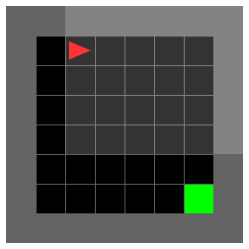

In [3]:
# create simple environment
import xminigrid

key = jax.random.key(0)
key, reset_key = jax.random.split(key)

# to list available environments: xminigrid.registered_environments()
env, env_params = xminigrid.make("MiniGrid-Empty-8x8")
print("Observation shape:", env.observation_shape(env_params))
print("Num actions:", env.num_actions(env_params))

# fully jit-compatible step and reset methods
timestep = jax.jit(env.reset)(env_params, reset_key)
timestep = jax.jit(env.step)(env_params, timestep, action=0)

print("TimeStep shapes:", jtu.tree_map(jnp.shape, timestep))

show_img(env.render(env_params, timestep), dpi=64)

In [6]:
# first four registered standard environments
xminigrid.registered_environments()[:4]

('XLand-MiniGrid-R1-9x9',
 'XLand-MiniGrid-R1-11x11',
 'XLand-MiniGrid-R1-13x13',
 'XLand-MiniGrid-R1-15x15')

In [7]:
xminigrid.register(
    id="MiniGrid-EmptyRandom-9x9",
    entry_point="xminigrid.envs.minigrid.empty:EmptyRandom",
    height=9,
    width=9
)

In [8]:
xminigrid.register(
    id="MiniGrid",
    entry_point="xminigrid.envs.minigrid.empty:EmptyRandom",
    height=9,
    width=9
)

Params: EnvParams(height=9, width=9, view_size=3, max_steps=324, render_mode='rgb_array')


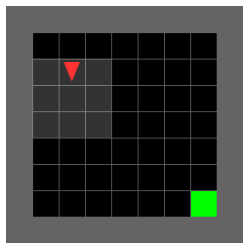

In [9]:
env, env_params = xminigrid.make("MiniGrid-EmptyRandom-9x9", view_size=3)
timestep = jax.jit(env.reset)(env_params, reset_key)

print("Params:", env_params)
show_img(env.render(env_params, timestep), dpi=64)

In [5]:
# scan through entire episodes with random policy (advantage of jit-compatible environments)
# vectorize and paralleize with vmap and pmap transformations
from xminigrid.wrappers import GymAutoResetWrapper

# alternatively users can provide step_fn and reset_fn instead
# of the closure, but in whis way it is simpler to use after the creation
def build_rollout(env, env_params, num_steps):
    def rollout(rng):
        def _step_fn(carry, _):
            rng, timestep = carry
            rng, _rng = jax.random.split(rng)
            action = jax.random.randint(_rng, shape=(), minval=0, maxval=env.num_actions(env_params))

            timestep = env.step(env_params, timestep, action)
            return (rng, timestep), timestep

        rng, _rng = jax.random.split(rng)

        timestep = env.reset(env_params, _rng)
        rng, transitions = jax.lax.scan(_step_fn, (rng, timestep), None, length=num_steps)
        return transitions

    return rollout


env, env_params = xminigrid.make("MiniGrid-EmptyRandom-8x8")
# do not forget to use auto reset wrapper!
env = GymAutoResetWrapper(env)

# jiting the entire rollout
rollout_fn = jax.jit(build_rollout(env, env_params, num_steps=1000))

# first execution will compile
transitions = rollout_fn(jax.random.key(0))

print("Transitions shapes: \n", jtu.tree_map(jnp.shape, transitions))

Transitions shapes: 
 TimeStep(state=State(key=(1000,), step_num=(1000,), grid=(1000, 8, 8, 2), agent=AgentState(position=(1000, 2), direction=(1000,), pocket=(1000, 2)), goal_encoding=(1000, 5), rule_encoding=(1000, 1, 7), carry=EnvCarry()), step_type=(1000,), reward=(1000,), discount=(1000,), observation=(1000, 7, 7, 2))


In [10]:
# VISUALIZATION
# record all timesteps and render them with env.render
images = []

for i in trange(1000):
    timestep = jtu.tree_map(lambda x: x[i], transitions)
    images.append(env.render(env_params, timestep))

imageio.mimsave("example_rollout.mp4", images, fps=32, format="mp4")

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/lib/python3.12/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


In [11]:
# VECTORIZATION
# vectorize the rollout with jax.vmap
vmap_rollout = jax.jit(jax.vmap(build_rollout(env, env_params, num_steps=1000)))
rngs = jax.random.split(jax.random.key(0), num=1024)

vmap_transitions = vmap_rollout(rngs)

print("Transitions shapes: \n", jtu.tree_map(jnp.shape, vmap_transitions))

Transitions shapes: 
 TimeStep(state=State(key=(1024, 1000), step_num=(1024, 1000), grid=(1024, 1000, 9, 9, 2), agent=AgentState(position=(1024, 1000, 2), direction=(1024, 1000), pocket=(1024, 1000, 2)), goal_encoding=(1024, 1000, 5), rule_encoding=(1024, 1000, 1, 7), carry=EnvCarry()), step_type=(1024, 1000), reward=(1024, 1000), discount=(1024, 1000), observation=(1024, 1000, 3, 3, 2))


In [12]:
# PARALLELIZE among devices available iwth jax.pmap
# pmap will jit
pmap_rollout = jax.pmap(jax.vmap(build_rollout(env, env_params, 1000)))
pmap_rngs = rngs.reshape(jax.local_device_count(), 1024 // jax.local_device_count()) #, -1 )

pmap_transitions = pmap_rollout(pmap_rngs)
print("Transitions shapes: \n", jtu.tree_map(jnp.shape, pmap_transitions))

Transitions shapes: 
 TimeStep(state=State(key=(1, 1024, 1000), step_num=(1, 1024, 1000), grid=(1, 1024, 1000, 9, 9, 2), agent=AgentState(position=(1, 1024, 1000, 2), direction=(1, 1024, 1000), pocket=(1, 1024, 1000, 2)), goal_encoding=(1, 1024, 1000, 5), rule_encoding=(1, 1024, 1000, 1, 7), carry=EnvCarry()), step_type=(1, 1024, 1000), reward=(1, 1024, 1000), discount=(1, 1024, 1000), observation=(1, 1024, 1000, 3, 3, 2))


In [13]:
# build benchmark to measure FPS (frames(environment) per second) for a random policy
# a simple baseline used for exploration and initial testing in RL
# where an agent chooses actions uniformly at random from the available action space

def build_benchmark(env_id, num_envs, timesteps):
    env, env_params = xminigrid.make(env_id)
    env = GymAutoResetWrapper(env)

    def benchmark_fn(key):
        def _step_fn(timestep, action):
            new_timestep = jax.vmap(env.step, in_axes=(None, 0, 0))(env_params, timestep, action)
            return new_timestep, None

        key, actions_key = jax.random.split(key)
        keys = jax.random.split(key, num=num_envs)
        actions = jax.random.randint(
            actions_key, shape=(timesteps, num_envs), minval=0, maxval=env.num_actions(env_params)
        )
        timestep = jax.vmap(env.reset, in_axes=(None, 0))(env_params, keys)
        timestep = jax.lax.scan(_step_fn, timestep, actions, unroll=1)[0]
        return timestep

    return benchmark_fn


# see https://stackoverflow.com/questions/56763416/what-is-diffrence-between-number-and-repeat-in-python-timeit
# on why we divide by num_iter
def timeit_benchmark(benchmark_fn, num_iter=1, num_repeat=10):
    benchmark_fn().state.grid.block_until_ready()
    times = timeit.repeat(
        lambda: benchmark_fn().state.grid.block_until_ready(),
        number=num_iter,
        repeat=num_repeat,
    )
    times = np.array(times) / num_iter
    elapsed_time = np.max(times)

    return elapsed_time

In [14]:
num_devices = jax.local_device_count()
envs_range = [512, 1024, 2048, 4096, 8192]
print("Num devices for pmap:", num_devices)

vmap_stats, pmap_stats = [], []
for num_envs in tqdm(envs_range):
    # building vmap for vectorization benchmarking
    benchmark_fn_vmap = build_benchmark("MiniGrid-EmptyRandom-8x8", num_envs, 1024)
    benchmark_fn_vmap = jax.jit(benchmark_fn_vmap)
    # building pmap for multi-gpu benchmarking (each doing (num_envs / num_devices) vmaps)
    benchmark_fn_pmap = build_benchmark("MiniGrid-EmptyRandom-8x8", num_envs // num_devices, 1024)
    benchmark_fn_pmap = jax.pmap(benchmark_fn_pmap)

    key = jax.random.key(0)
    pmap_keys = jax.random.split(key, num=num_devices)

    elapsed_time = timeit_benchmark(jax.tree_util.Partial(benchmark_fn_vmap, key))
    vmap_fps = (1024 * num_envs) / elapsed_time

    elapsed_time = timeit_benchmark(jax.tree_util.Partial(benchmark_fn_pmap, pmap_keys))
    pmap_fps = (1024 * num_envs) / elapsed_time

    vmap_stats.append(vmap_fps)
    pmap_stats.append(pmap_fps)

Num devices for pmap: 1


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for n, vfps, pfps in zip(envs_range, vmap_stats, pmap_stats):
    print(f"{n} envs. vmap fps: {vfps}, pmap fps: {pfps}")

In [ ]:
plt.plot(envs_range, vmap_stats, "o-", label="vmap", linewidth=2.0);
plt.plot(envs_range, pmap_stats, "o-", label="pmap", linewidth=2.0);
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.grid();
plt.ylabel("Steps per second");
plt.xlabel("Environments")
plt.legend(loc="upper left");

In [ ]:
# utils for the demonstation
from xminigrid.core.grid import room
from xminigrid.types import AgentState
from xminigrid.core.actions import take_action
from xminigrid.core.constants import Tiles, Colors, TILES_REGISTRY
from xminigrid.rendering.rgb_render import render

# rules: functions that can change the environment state
# goals (functions(classes in code) take in arguments and validates some conditions):
#do not change state, only test conditions
from xminigrid.core.goals import check_goal, AgentNearGoal
from xminigrid.core.rules import check_rule, AgentNearRule

In [ ]:
'''
Setup simple ONE-ROOM environment:
function spawns one yellow ball near the agent
perform an action moving agent one tile forward with "take_action"
returns: updated grid, agent and also some position of objecgt that somehow changes
needed for goals and rules checking
'''
# for testing
grid = room(6, 6)
grid = grid.at[1, 1].set(TILES_REGISTRY[Tiles.BALL, Colors.YELLOW])

agent = AgentState(position=jnp.array((1, 3)), direction=3)

# taking move forward action
move_forward_action = jnp.asarray(0)
new_grid, new_agent, position = take_action(grid, agent, move_forward_action)

show_img(render(grid, agent), dpi=64)
show_img(render(new_grid, new_agent), dpi=64)